## **Bayesian Neural Networks on simulated data**

In this notebook we train a Convolutional Bayesian Neural Network (C-BNN)

### **Part I: Create Simulations**

(Based on Alex Drlica-Wagner's code)

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse

# Colab in order to download files
from google.colab import files

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [2]:
SIZE = 64
DTYPE = [
    ('id',int),                # object id
    ('x',float),               # x-centroid
    ('y',float),               # y-centroid
    ('nsig',int),              # number of signal photons
    ('nbkg',float),            # mean number of background photons
    ('reff',float),            # azimuthally averaged radius [a * sqrt(1 -ell)]
    ('ell',float),             # ellipticity
    ('phi',float),             # position angle
]

**Write function that creates population**

In [3]:
def create_population(nsim=100, nsig=10000, nbkg=10, 
                      x=SIZE//2, y=SIZE//2, reff=100, ell=0, phi=0):
                      
                      
    """ Create the population parameters
    Parameters
    ----------
    nsim : number of simulations
    nsig : number of signal photons 
    nbkg : number of background photons
    x,y  : centroid location [pix]
    reff : azimuthally averaged radius [pix]
    ell  : ellipticity
    phi  : position angle [deg]
    """
    # Could probably do something clever with
    #inspect.getargvalues(inspect.currentframe())

    ones = np.array([1,1])
    x *= ones
    y *= ones
    nsig *= ones
    nbkg *= ones
    reff *= ones
    ell *= ones
    phi *= ones

    params = np.recarray(nsim,dtype=DTYPE)
    params['id']   = np.arange(nsim)
    params['x']    = np.random.uniform(x[0],x[1],nsim)
    params['y']    = np.random.uniform(y[0],y[1],nsim)
    params['nsig'] = np.random.uniform(nsig[0],nsig[1],nsim)
    params['nbkg'] = np.random.uniform(nbkg[0],nbkg[1],nsim)    
    params['reff'] = np.random.uniform(reff[0],reff[1],nsim)
    #params['nsig'] = np.random.uniform(nsig[0],nsig[1],nsim)*params['reff']# That way we make them correlated 
    params['ell']  = np.random.uniform(ell[0],ell[1],nsim)
    params['phi']  = np.random.uniform(phi[0],phi[1],nsim)

    return params

**Functions that creates simulated galaxies and background, and final image**

In [4]:
# Function that creates the galaxy
def create_galaxy(params):
    """Create the galaxy from a 2D Gaussian distribution"""
    nsig = params['nsig']
    mean = [params['x'],params['y']]
    reff = params['reff']
    ell  = params['ell']
    phi  = params['phi']

    a = reff / np.sqrt(1 - ell)
    b = reff**2 / a

    # https://stackoverflow.com/a/54442206/4075339
    cov_xx = a**2 * np.cos(np.radians(phi))**2 + b**2 * np.sin(np.radians(phi))**2
    cov_yy = a**2 * np.sin(np.radians(phi))**2 + b**2 * np.cos(np.radians(phi))**2
    cov_xy = (a**2 - b**2) * np.sin(np.radians(phi)) * np.cos(np.radians(phi)) 

    cov = np.array([[cov_xx,cov_xy],[cov_xy,cov_yy]])

    # List of photons
    sig = np.random.multivariate_normal(mean,cov,size=nsig)
    cut = np.any((sig < 0) | (sig > SIZE), axis=1)
    if np.any(cut == True):
        #print(f"WARNING: {cut.sum()} photons outside of image")
        sig = sig[~cut]
        
    img = np.zeros(shape=(SIZE,SIZE))
    xidx = sig[:,0].astype(int)
    yidx = sig[:,1].astype(int)
    np.add.at(img, (yidx,xidx), 1)
    return img


# ==============================================================================
# ==============================================================================
# Function that creates background
def create_background(params):
    """ Create uniform background from poisson distribution """
    nbkg = params['nbkg']
    img = scipy.stats.poisson.rvs(nbkg, size=(SIZE,SIZE))
    return img

# ==============================================================================
# ==============================================================================
# Function that creates image
def create_image(params):
    """Simulate a 2D gaussian with noise from a set of params"""
    bkg = create_background(params)
    sig = create_galaxy(params)
    img = bkg + sig

    return img


**Functions that create and draw ellipses**

In [5]:
# Create ellipse
def create_ellipse(params, **kwargs):
    """ Create matplotlib.patches.Ellipse """
    mean = [params['x'],params['y']]
    reff = params['reff']
    ell  = params['ell']
    phi  = params['phi']

    a = reff / np.sqrt(1 - ell)
    b = reff**2 / a
    
    return Ellipse(mean, 2*a, 2*b, angle=phi, **kwargs)

# ==============================================================
# ==============================================================
# Draw ellipse
def draw_ellipse(params, **kwargs):
    """ Draw the matplotlib ellipse """
    ellipse = create_ellipse(params,**kwargs)
    ax = plt.gca()
    ax.add_artist(ellipse)
    return ax, ellipse

### **Part II: Create training set**

In [6]:
catalog = create_population(nsim=30000,nsig=[10000,13000],reff=[2.5,10], ell=[0.,0.5],phi=[0.,180.])

reff_true = catalog['reff'] # Get effective radius -  true values
nsig_true = catalog['nsig'] # Get number of signal photons - true values
ell_true = catalog['ell'] # Get ellipticity

nsig_norm = nsig_true/1000.


In [7]:
images_training = []
for i,params in enumerate(catalog):
    img = create_image(params)
    images_training.append(img)

In [8]:
# Print maximum brightness
max_br = np.max(images_training)

print(max_br)

nsig_norm = nsig_true/10000.

359.0


**Let's now plot some simulated galaxy image examples**

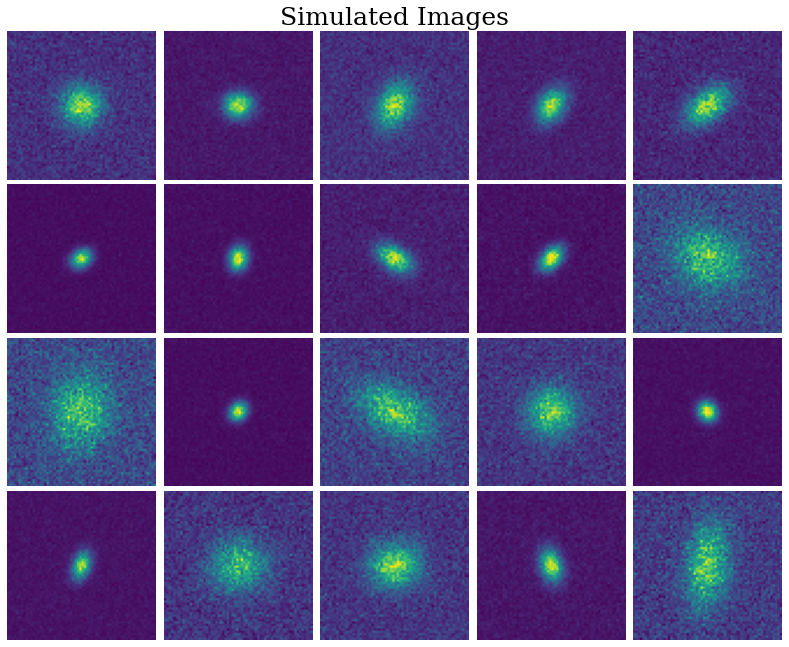

In [9]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Simulated Images",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_training[i]/365.)
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

Now, recreate the training set with three identical channels and normalized values

In [10]:
X_gals_tr_3ch = np.zeros([30000,64,64,3])

for i in range(30000):
  input = images_training[i]/np.max(images_training[i])
  # 
  X_gals_tr_3ch[i,:,:,0] = input
  X_gals_tr_3ch[i,:,:,1] = input
  X_gals_tr_3ch[i,:,:,2] = input

### **Part III: $R_{eff}$ and $N_{sig}$ prediction using BNNs**


In [11]:
# Import libraries

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp



from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# ======================================
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
# Concatenate the half-light radius, the magnitude g, and the ellipticity
y_tot = np.column_stack((reff_true,nsig_norm,ell_true))

In [13]:
# Define basic numbers
IMAGE_SHAPE = [64, 64, 3]
NUM_TRAIN_EXAMPLES = 27000
NUM_VAL_EXAMPLES = 2000
NUM_TEST_EXAMPLES = 1000
NUM_CLASSES = 3

**Define KL divergence function**

In [14]:
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

**Build the model**

In [15]:
# Bayesian DeepShadows in functional form
model_input = Input(shape=(64,64,3))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          activity_regularizer = regularizers.l2(0.15),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          activity_regularizer = regularizers.l2(0.15),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          activity_regularizer = regularizers.l2(0.15),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 128, 
          kernel_size=(3,3),
          activity_regularizer = regularizers.l2(0.15),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# ====================================
x = keras.layers.Flatten()(x)
# ====================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          activity_regularizer = regularizers.l2(0.12),
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
#distribution_params = keras.layers.Dense(units=4)(x)
#d = tf.dimension_value(2)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(3))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=3)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [16]:
# Define loss
def negloglik(y_true, y_pred):
    y_pred = tfp.distributions.MultivariateNormalTriL(y_pred)
    return -tf.reduce_mean(y_pred.log_prob(y_true))


# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2)
model.compile(optimizer,
              loss=negloglik,
              metrics=['mae'],experimental_run_tf_function=False)

In [17]:
model.fit(x=X_gals_tr_3ch[0:27000], y=y_tot[0:27000],
          epochs=120, batch_size=64,
          shuffle=True,
          validation_data=(X_gals_tr_3ch[27000:29000],y_tot[27000:29000]))

Epoch 1/120
422/422 [==============================] - 14s 20ms/step - loss: 329.4825 - mae: 0.8329 - val_loss: 221.5048 - val_mae: 0.4807
Epoch 2/120
422/422 [==============================] - 7s 16ms/step - loss: 215.0870 - mae: 0.4193 - val_loss: 211.3994 - val_mae: 0.3684
Epoch 3/120
422/422 [==============================] - 7s 16ms/step - loss: 209.8844 - mae: 0.3357 - val_loss: 208.9228 - val_mae: 0.3107
Epoch 4/120
422/422 [==============================] - 7s 16ms/step - loss: 208.6164 - mae: 0.2941 - val_loss: 208.3186 - val_mae: 0.2817
Epoch 5/120
422/422 [==============================] - 7s 16ms/step - loss: 208.1239 - mae: 0.2748 - val_loss: 207.9141 - val_mae: 0.2691
Epoch 6/120
422/422 [==============================] - 7s 16ms/step - loss: 207.7607 - mae: 0.2625 - val_loss: 207.5730 - val_mae: 0.2526
Epoch 7/120
422/422 [==============================] - 7s 16ms/step - loss: 207.4573 - mae: 0.2586 - val_loss: 207.3140 - val_mae: 0.2578
Epoch 8/120
422/422 [============

## Predictions

#### **Make prediction for a single "galaxy"**

In [123]:
i = 29003
X_0 = X_gals_tr_3ch[i]
y_0 = y_tot[i]
print(y_0)

[7.71585858 1.0611     0.48805148]


In [124]:
pred_dist = model(X_0.reshape(1,64,64,3))

In [126]:
prediction_mean = pred_dist.mean().numpy()[0]
prediction_cov = pred_dist.covariance().numpy()[0]
print(prediction_mean)
print(prediction_cov)
preds = np.random.multivariate_normal(prediction_mean,prediction_cov,200)


[7.997068   1.1409998  0.24539343]
[[ 3.3601205e-05 -1.9555104e-05 -2.7058800e-06]
 [-1.9555104e-05  4.5266184e-05 -6.5190429e-06]
 [-2.7058800e-06 -6.5190429e-06  3.4528195e-05]]


In [127]:
#preds = np.random.multivariate_normal(prediction_mean,prediction_cov,200)

n_rands = 700
for i in range(n_rands):
  pred_dist = model(X_0.reshape(1,64,64,3))
  prediction_mean = pred_dist.mean().numpy()[0]
  prediction_cov = pred_dist.covariance().numpy()[0]
  preds_loc = np.random.multivariate_normal(prediction_mean,prediction_cov,5)
  preds = np.concatenate((preds,preds_loc))

In [24]:
print(np.shape(preds))
np.save('preds',preds)

(3700, 3)


In [35]:
#!pip install chainconsumer
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super

In [25]:
from chainconsumer import ChainConsumer

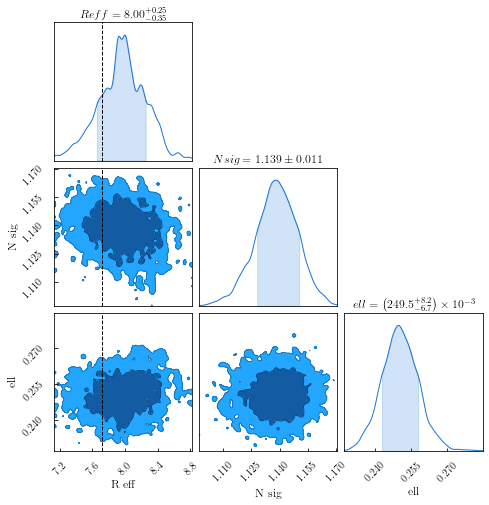

In [128]:
c = ChainConsumer()
c.add_chain(np.asarray(preds),parameters=["R eff", "N sig", "ell"])
fig = c.plotter.plot(figsize=(7,7), truth=y_0)

In [129]:
print(np.percentile(preds[:,0], [2.5,97.5]))
print(np.percentile(preds[:,1], [2.5,97.5]))

[7.35789155 8.49903122]
[1.11493807 1.15954105]


In [136]:
params_loc = catalog[29003]
#params_loc['reff'] = 6.78
print(params_loc)
params_low  = np.record.copy(catalog[29003])
params_low['reff'] = 7.357
params_up = np.record.copy(catalog[29003])
params_up['reff'] = 8.499

(29003, 32., 32., 10611, 10., 7.71585858, 0.48805148, 179.68357718)


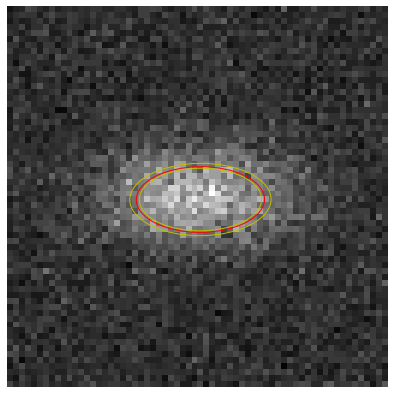

In [137]:
plt.figure(figsize=(7, 7))

plt.imshow(X_0)
plt.axis('off')
draw_ellipse(params_loc,fill=False,color='r',zorder=1)
draw_ellipse(params_low,fill=False,color='y',zorder=1)
draw_ellipse(params_up,fill=False,color='y',zorder=1)
#plt.savefig("Galaxy_example.pdf")
#files.download("Galaxy_example.pdf")
plt.show()

### Comparison with pyImfit

Fit Gaussian profile using pyImfit

In [138]:
#!pip3 install pyimfit
import pyimfit

Fit Gaussian model

In [189]:
model_desc = pyimfit.SimpleModelDescription()
# define the X0,Y0 initial guess and limits
model_desc.x0.setValue(32.0, [20,40])
model_desc.y0.setValue(32.0, [20,40])
# create a Gaussian image function and set its parameters' initial guesses and limits
Gauss_function = pyimfit.make_imfit_function("Gaussian")
Gauss_function.PA.setValue(10, [-180,180])
Gauss_function.ell.setValue(0.2, [-0.7,0.7])
Gauss_function.I_0.setValue(250, [0,100])
Gauss_function.sigma.setValue(5.0, [0.1,30.0])
# now add the image function to the model
model_desc.addFunction(Gauss_function)

In [190]:
imfit_fitter = pyimfit.Imfit(model_desc)
imfit_fitter.loadData(X_0[:,:,0])

In [191]:
results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params
err_bestfit = results.paramErrs

print(p_bestfit)
print(err_bestfit)

[32.7996635  32.41856616 -1.0860015  -0.2416628   0.29151225 26.1016022 ]
[ 2.1250166   1.42909271 14.20424136  0.18716091  0.01917438  2.40837775]


In [192]:
nIterations = 1500

imfit_fitter.doFit()
parameterNames, bootstrapResults = imfit_fitter.runBootstrap(nIterations, getColumnNames=True)

In [182]:
print(parameterNames)

['X0_1', 'Y0_1', 'PA_1', 'ell_1', 'I_0_1', 'sigma_1']


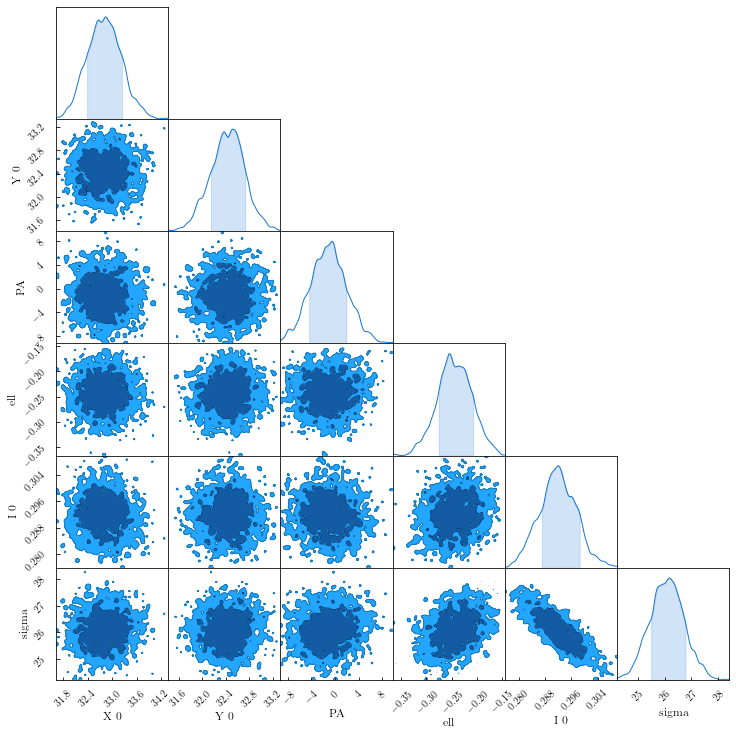

In [193]:
c = ChainConsumer()
c.add_chain(bootstrapResults, parameters=["X 0", "Y 0", 'PA', 'ell', 'I 0', 'sigma'])
fig = c.plotter.plot(figsize=(11,11))

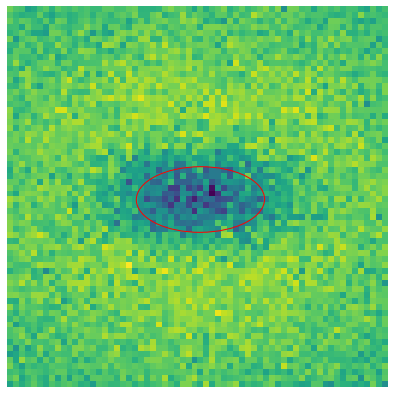

In [194]:
bestfit_model_im = imfit_fitter.getModelImage()
res = bestfit_model_im - X_0[:,:,0]
plt.figure(figsize=(7, 7))

plt.imshow(res)
plt.axis('off')
draw_ellipse(catalog[29003],fill=False,color='r',zorder=1)
#plt.savefig("Galaxy_example.pdf")
#files.download("Galaxy_example.pdf")
plt.show()